<a href="https://colab.research.google.com/github/Hrithik2212/Indian-News-Classification/blob/main/NewsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Classification on the Indian Fake News Dataset from Kaggle

In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings('ignore')
import re 
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split as tts 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



## Data Exploration and Preprocessing 

In [48]:
data = pd.read_csv('/content/news_dataset.csv')
data.head(1)

,label,text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3729 entries, 0 to 3728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3729 non-null   object
 1   text    3721 non-null   object
dtypes: object(2)
memory usage: 58.4+ KB


Text(0.5, 1.0, 'Target Distribution')

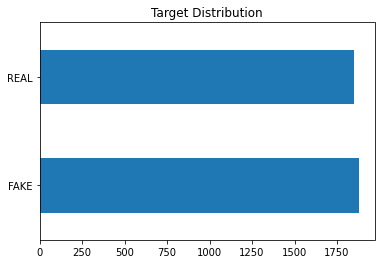

In [50]:
m = data.label.value_counts()
m.plot(kind='barh')
plt.title("Target Distribution")

In [51]:
data['text']

0       Payal has accused filmmaker Anurag Kashyap of ...
1       A four-minute-long video of a woman criticisin...
2       Republic Poll, a fake Twitter account imitatin...
3       Delhi teen finds place on UN green list, turns...
4       Delhi: A high-level meeting underway at reside...
                              ...                        
3724    19:17 (IST) Sep 20\n\nThe second round of coun...
3725    19:17 (IST) Sep 20\n\nThe second round of coun...
3726    The Bengaluru City Police’s official Twitter h...
3727    Sep 20, 2020, 08:00AM IST\n\nSource: TOI.in\n\...
3728    Read Also\n\nRead Also\n\nAdvocate Ishkaran Bh...
Name: text, Length: 3729, dtype: object

In [52]:
# stopword removal
stop_words = set(stopwords.words('english'))
def sw_remove(text) :
  words = [word for word in str(text).split() if word.lower() not in stop_words]
  txt = ' '.join([str(elem) for elem in words])
  return txt 

for i in range(len(data)):
  data['text'][i] = sw_remove(data['text'][i])
# data['text'] = data['text'].apply(sw_remove)

In [53]:
data['label'] = data['label'].apply(lambda x:0 if x == 'FAKE' else 1)

In [54]:
X_train , X_test , y_train , y_test = tts(data['text'],data['label'],test_size=0.2)
len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2983, 746, 2983, 746)

In [57]:
def plot_metrics(y_pred , y_test):
  print(cr(y_test , y_pred))
  sns.heatmap(cm(y_test,y_pred),annot =True , fmt = 'g' ,cmap='Blues')
     

## Naive Bayes 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       408
           1       0.96      0.99      0.98       338

    accuracy                           0.98       746
   macro avg       0.98      0.98      0.98       746
weighted avg       0.98      0.98      0.98       746



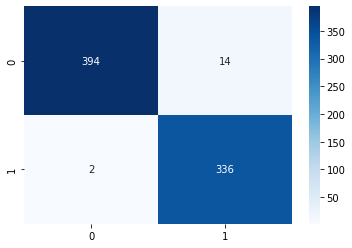

In [58]:
model0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("Bayes_Classifier", MultinomialNB()) # model the text
])
model0.fit(X_train , y_train)
y_pred = model0.predict(X_test)
plot_metrics(y_test,y_pred)

## Single Layer Perceptron

In [63]:
text_vectorizer = TextVectorization(max_tokens = 20000,
                                   output_mode= 'int' ,
                                   output_sequence_length=25,
                                   )
text_vectorizer.adapt(X_train)

In [61]:
embedding = layers.Embedding(input_dim=20000, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=25, # how long is each input
                             name="embedding_1") 

embedding
     

In [64]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
dense1 = layers.Dense(128, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.L1(0.01),
                      activity_regularizer=tf.keras.regularizers.L2(0.01))(x) 
dropout = layers.Dropout(0.5)(dense1)
outputs = layers.Dense(1,activation = 'sigmoid')(dropout) # create the output layer, want binary outputs so use sigmoid activation
Model_1 = tf.keras.Model(inputs, outputs, name="FNN") # construct the model
Model_1.summary()

Model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

Model_1_history = Model_1.fit(X_train,
                              y_train,
                              epochs =10,
                              validation_data = (X_test,y_test),
                              )
     

Model: "FNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 25)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 25, 128)           2560000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0       

## RNN

In [66]:
from keras import initializers

Model_2 = Sequential()
Model_2.add(Input(shape=(1,),dtype='string'))
Model_2.add(text_vectorizer)
Model_2.add(embedding)
Model_2.add(tf.keras.layers.SimpleRNN(24,
                                      kernel_initializer=initializers.RandomNormal(stddev=0.001),
                                      recurrent_initializer=initializers.Identity(gain=1.0)))
Model_2.add(layers.Dropout(0.8))
Model_2.add(Dense(24,activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.L1(0.2),
                  activity_regularizer=tf.keras.regularizers.L2(0.1)))
Model_2.add(Dense(1,activation ='sigmoid'))
Model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 25)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 25, 128)           2560000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                3672      
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                      

In [68]:
Model_2.compile(loss = 'binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

Model_2_history = Model_2.fit(X_train,
                              y_train,
                              epochs =10,
                              validation_data = (X_test,y_test),
                              )

Epoch 1/10
94/94 [==============================] - 7s 53ms/step - loss: 16.7480 - accuracy: 0.9239 - val_loss: 11.9537 - val_accuracy: 0.9893
Epoch 2/10
94/94 [==============================] - 5s 57ms/step - loss: 8.4225 - accuracy: 0.9809 - val_loss: 5.1256 - val_accuracy: 0.9839
Epoch 3/10
94/94 [==============================] - 4s 45ms/step - loss: 3.0633 - accuracy: 0.9826 - val_loss: 1.3926 - val_accuracy: 0.9611
Epoch 4/10
94/94 [==============================] - 5s 52ms/step - loss: 0.8805 - accuracy: 0.9849 - val_loss: 0.6841 - val_accuracy: 0.9598
Epoch 5/10
94/94 [==============================] - 5s 53ms/step - loss: 0.6664 - accuracy: 0.9886 - val_loss: 0.6586 - val_accuracy: 0.9491
Epoch 6/10
94/94 [==============================] - 4s 46ms/step - loss: 0.6352 - accuracy: 0.9889 - val_loss: 0.6361 - val_accuracy: 0.9450
Epoch 7/10
94/94 [==============================] - 5s 51ms/step - loss: 0.6119 - accuracy: 0.9899 - val_loss: 0.6132 - val_accuracy: 0.9450
Epoch 8/10


## LSTM 

In [69]:

from tensorflow.keras import regularizers
Model_3 = Sequential()
Model_3.add(Input(shape=(1,),dtype='string'))
Model_3.add(text_vectorizer)
Model_3.add(embedding)
Model_3.add(layers.LSTM(64))
Model_3.add(Dense(64,activation ='relu',
            kernel_regularizer = regularizers.L1(0.1),
            activity_regularizer= regularizers.L2(0.01)))
Model_3.add(Dropout(0.8))
Model_3.add(Dense(1,activation = 'sigmoid'))
Model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 25)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 25, 128)           2560000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

In [70]:
Model_3.compile(loss='binary_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])
Model_3_history = Model_3.fit(X_train,
                              y_train,
                              epochs =10,
                              validation_data = (X_test,y_test),
                              )

Epoch 1/10
94/94 [==============================] - 9s 66ms/step - loss: 28.4186 - accuracy: 0.9745 - val_loss: 14.4989 - val_accuracy: 0.9732
Epoch 2/10
94/94 [==============================] - 5s 57ms/step - loss: 6.5711 - accuracy: 0.9936 - val_loss: 1.3716 - val_accuracy: 0.9732
Epoch 3/10
94/94 [==============================] - 5s 52ms/step - loss: 0.7577 - accuracy: 0.9722 - val_loss: 0.6382 - val_accuracy: 0.9705
Epoch 4/10
94/94 [==============================] - 6s 66ms/step - loss: 0.6181 - accuracy: 0.9675 - val_loss: 0.5979 - val_accuracy: 0.9665
Epoch 5/10
94/94 [==============================] - 5s 53ms/step - loss: 0.5908 - accuracy: 0.9661 - val_loss: 0.5697 - val_accuracy: 0.9665
Epoch 6/10
94/94 [==============================] - 5s 57ms/step - loss: 0.5642 - accuracy: 0.9648 - val_loss: 0.5490 - val_accuracy: 0.9665
Epoch 7/10
94/94 [==============================] - 6s 64ms/step - loss: 0.5445 - accuracy: 0.9651 - val_loss: 0.5287 - val_accuracy: 0.9638
Epoch 8/10


## Evaluation and Comparision

In [72]:

Evaluation_Table = pd.DataFrame(columns=['Model','Accuracy','Precission','F1 Score','Recall','ROC_AUC'])
MN = []
As =[]
ps =[]
f1 =[]
rs =[]
auc =[]
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score ,roc_auc_score
def add2table(model ,model_name,X =X_test , y =y_test):
  y_pred = model.predict(X)
  MN.append(model_name)
  As.append(accuracy_score(y,tf.round(y_pred)))
  ps.append(precision_score(y,tf.round(y_pred)))
  f1.append(f1_score(y,tf.round(y_pred)))
  rs.append(recall_score(y,tf.round(y_pred)))
  auc.append(roc_auc_score(y,tf.round(y_pred))) 

In [73]:
add2table(model0,'Naive Bayes')
add2table(Model_1,'ANN - TwoLayers')
add2table(Model_2,'Simple RNN')
add2table(Model_3,'LSTM')

24/24 [==============================] - 1s 10ms/step


In [74]:
Evaluation_Table = pd.DataFrame(np.array([MN,As,ps,f1,rs,auc]).T,
                                columns=['Model','Accuracy','Precission','F1 Score','Recall','ROC_AUC'])
for col in Evaluation_Table.columns:
  try : 
    Evaluation_Table[col] = Evaluation_Table[col].astype('float')
    Evaluation_Table[col] = Evaluation_Table[col].apply(np.round(decimals =2))
  except :
    continue 
Evaluation_Table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Model       4 non-null      object 
 1   Accuracy    4 non-null      float64
 2   Precission  4 non-null      float64
 3   F1 Score    4 non-null      float64
 4   Recall      4 non-null      float64
 5   ROC_AUC     4 non-null      float64
dtypes: float64(5), object(1)
memory usage: 320.0+ bytes


In [75]:
Evaluation_Table

,Model,Accuracy,Precission,F1 Score,Recall,ROC_AUC
0,Naive Bayes,0.978552,0.994083,0.976744,0.960000,0.977475
1,ANN - TwoLayers,0.990617,0.985836,0.990043,0.994286,0.990830
2,Simple RNN,0.943700,0.918478,0.941504,0.965714,0.944978
3,LSTM,0.962466,0.939891,0.960894,0.982857,0.963651


In [78]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model ,model_name,X = X_test , y = y_test):
  y_pred = tf.round(model.predict(X))
  cf_matrix= confusion_matrix(y,y_pred)
  ax = sns.heatmap(cf_matrix, annot=True,fmt='d',cmap='Blues')

  ax.set_title(model_name);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['FAKE','REAL'])
  ax.yaxis.set_ticklabels(['FAKE','REAL'])
     

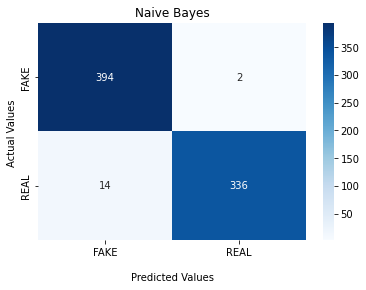

In [79]:
plot_confusion_matrix(model0,'Naive Bayes')

24/24 [==============================] - 0s 5ms/step


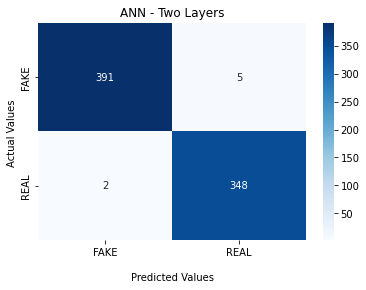

In [80]:
plot_confusion_matrix(Model_1,'ANN - Two Layers')

24/24 [==============================] - 0s 6ms/step


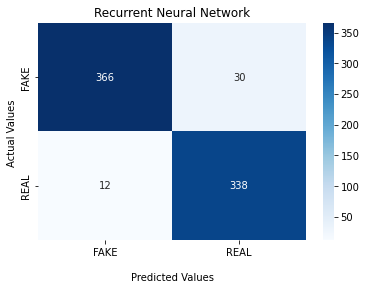

In [82]:
plot_confusion_matrix(Model_2,'Recurrent Neural Network')

24/24 [==============================] - 0s 10ms/step


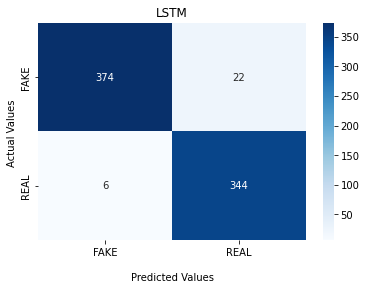

In [83]:
plot_confusion_matrix(Model_3,'LSTM')

# The best performing model is the ANN with Two Layers with 99% accuracy